# 4. pix2pix with the Victorian400 dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/GAN/Ch4-pix2pix.ipynb)

이전 장에서는 GAN 모델을 이용하여, 흑백 이미지를 컬러 이미지로 변환해보았습니다. 

이번 장에서는 cGAN (conditional Generative Adversarial Network) 기반인 [pix2pix](https://phillipi.github.io/pix2pix/) 모델과 19세기 일러스트로 이루어진 [Victorian400](https://www.kaggle.com/elibooklover/victorian400) 데이터셋을 이용하여, 해당 모델을 학습하고 색채를 입히는 테스트 해보도록 하겠습니다.

## 4.1 데이터셋 다운로드

우선 Victorian400 데이터셋을 내려 받도록 하겠습니다. 가짜연구소에서 제작한 툴을 통해 해당 데이터셋을 내려받고 압축을 풀도록 하겠습니다.

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 7), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), done.
Victorian400-GAN-colorization-data.zip is done!


기본적인 모듈들을 import 해줍니다.

In [2]:
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torch.autograd import Variable

## 4.2 데이터셋 클래스 정의

`VictorianDataset` 클래스는 흑백사진(gray)과 컬러사진(resized)을 함께 파일명 순서대로 불러오는 `__init__` 함수, 각각의 이미지 파일을 픽셀로 저장하는 `__getitem__` 함수, 파일 갯수를 반환하는 `__len__` 함수가 지정되어 있습니다.

In [3]:
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):
        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("RGB")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)

배치 사이즈와 이미지 사이즈를 미리 지정해줍니다. 폴더 위치를 `root`로 지정해줍니다. 이미지 사이즈의 경우 높이와 가로 모두 256으로 맞춰줍니다. pix2pix 모델의 경우 256 x 256 이미지 사이즈를 활용합니다. (추가 할 것)

In [4]:
root = ''

batch_size = 12
img_height = 256
img_width = 256

`transform.Normalize`에서 `Normalize` 크기를 지정해줍니다. 2.4절에서 구한 평균과 표준편차로 normalize를 해주도록 하겠습니다. 

In [5]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533, 0.5350533, 0.5350533]
gray_std = [0.25051587, 0.25051587, 0.25051587]

color_transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

In [6]:
train_loader  = DataLoader(
    VictorianDataset(root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)

In [7]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

이제 불러온 데이터가 픽셀로 잘 저장이 되었는지, 시각화 해보도록 하겠습니다.

torch.Size([12, 3, 256, 256]) torch.Size([12, 3, 256, 256])


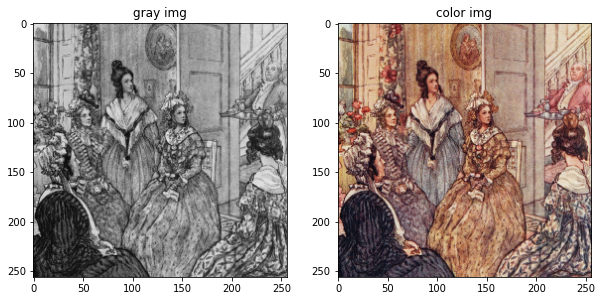

In [8]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in train_loader :

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std)) 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

## 4.3 모델 구축

이제 pix2pix 모델을 설계하도록 하겠습니다. pix2pix의 특징은 일반적인 인코더-디코더(Encoder-Decoder)보다는 U-NET을 사용합니다. U-NET의 특징은 일반적인 인코더-디코더와 달리 스킵 커넥션 (Skip Connections)이 있어, 인코더 레이어와 디코더 레이어 간의 연결을 보다 로컬라이징(localization)을 잘 해주는 특징이 있습니다. 예를 들어, 첫 인코더 레이어 크기가 256 x 256 x 3이라면, 마지막 디코더 레이어 크기도 똑같이 256 x 256 x 3이게 됩니다. 이렇게 같은 크기의 인코더-디코더 레이어가 결합하여, 보다 효과적이고 빠른 성능을 발휘할 수 있게 하는게 U-NET의 특징입니다.

이제 스킵 커넥션이 내장된 U-NET 생성자(Generator)를 설계해보도록 하겠습니다. 앞장에서 설명했듯이, GAN 모델에는 U-NET 생성자(Generator)가 있으며, 스킵 커넥션을 통해 인코더-디코더 레이어 간의 로컬라이징을 해줍니다.

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# U-NET 생성

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

이제 구분자(Discriminator)를 생성해보겠습니다.

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

이제 생성자(Generator)와 분별자(Discriminator)의 구조를 살펴보도록 하겠습니다.

In [11]:
GeneratorUNet().apply(weights_init_normal)

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

In [12]:
Discriminator().apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

이제 파라미터를 지정하고 pix2pix 모델을 학습해보도록 하겠습니다. 여기서 `n_epoch`은 총 학습할 에폭 횟수이고, `lr`는 학습 손실값(Learning Loss)을 의미합니다. `checkpoint_interval`은 학습중 모델의 가중치가 저장되는 간격입니다.

In [13]:
n_epochs = 100
dataset_name = "Victorian400"
lr = 0.0002
b1 = 0.5                    # adam: decay of first order momentum of gradient
b2 = 0.999                  # adam: decay of first order momentum of gradient
decay_epoch = 100           # epoch from which to start lr decay
#n_cpu = 8                   # number of cpu threads to use during batch generation
channels = 3                # number of image channels
checkpoint_interval = 20    # interval between model checkpoints

In [14]:
os.makedirs("images/%s/val" % dataset_name, exist_ok=True)
os.makedirs("images/%s/test" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

`sample_images` 함수 정의 부분을 보시면, `gray`, `color`, `output`가 있는데, 저는 `gray`를 흑백사진, `color`를 컬러사진, `output`를 흑백을 컬러화한 사진으로 정의하였습니다. `gray`가 `color`와 비교되면서 학습이 되고, 이를 바탕으로 `output`를 생성하게 됩니다.

In [15]:
def sample_images(epoch, loader, mode):
    imgs = next(iter(loader))
    gray = Variable(imgs["A"].type(Tensor))
    color = Variable(imgs["B"].type(Tensor))
    output = generator(gray)    
    
    gray_img = torchvision.utils.make_grid(gray.data, nrow=6) 
    color_img = torchvision.utils.make_grid(color.data, nrow=6)  
    output_img = torchvision.utils.make_grid(output.data, nrow=6)

    rows = 3
    cols = 1

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(gray_img.cpu(), gray_mean, gray_std)) 
    ax1.set_title('gray')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(color_img.cpu(), color_mean, color_std))
    ax2.set_title('color')  

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(reNormalize(output_img.cpu(), color_mean, color_std))
    ax3.set_title('output')  

    plt.show()
    fig.savefig("images/%s/%s/epoch_%s.png" % (dataset_name, mode, epoch), pad_inches=0)

## 4.4 모델 학습

이제 지정한 `epoch`만큼 학습을 시작해보도록 하겠습니다.

In [16]:
# ----------
#  Training
# ----------

for epoch in range(1, n_epochs+1):
    start_time = datetime.datetime.now()
    for i, batch in enumerate(train_loader):

        # Model inputs
        gray = Variable(batch["A"].type(Tensor))
        color = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((gray.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((gray.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        output = generator(gray)
        pred_fake = discriminator(output, gray)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(output, color)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(color, gray)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(output.detach(), gray)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        epoch_time = datetime.datetime.now() - start_time

    if (epoch) % checkpoint_interval == 0:
        fig = plt.figure(figsize=(18, 18))
        sample_images(epoch, train_loader, 'val')

        torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (dataset_name, epoch))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" % (epoch, 
                                                                                                    n_epochs, 
                                                                                                    i+1, 
                                                                                                    len(train_loader), 
                                                                                                    loss_D.item(), 
                                                                                                    loss_G.item(), 
                                                                                                    loss_pixel.item(), 
                                                                                                    loss_GAN.item(), 
                                                                                                    epoch_time))
     

Output hidden; open in https://colab.research.google.com to view.

위의 샘플 사진들을 보시면, 위에서 아래 순서대로 흑백-타켓-아웃풋 이미지입니다. 확실히 에폭수가 늘어남으로써 학습 효과가 나타나고 있는 걸 확인 할 수 있습니다. 이렇게 샘플링 된 이미지를 확인하면서 적절한 배치사이즈와 에폭수를 찾을 수 있습니다.

## 4.5 예측 및 성능 평가

이제 학습된 모델을 이용해 6장의 테스트셋으로 실험해보도록 하겠습니다.

In [17]:
test_root = root + 'test/'
test_batch_size = 6

test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

테스트셋 이미지 파일이 잘 출력되는지 확인해보도록 하겠습니다.

torch.Size([6, 3, 256, 256]) torch.Size([6, 3, 256, 256])


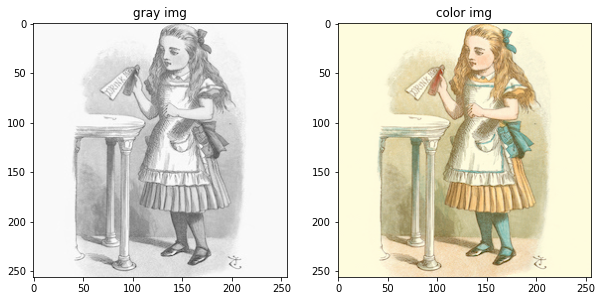

In [18]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in test_loader:

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std)) 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

이제 학습된 모델을 불러와 테스트셋 이미지 파일들을 예측해보도록 하겠습니다. 아래 코드는 최대 에폭수로 학습된 모델을 적용합니다. 원하는 에폭수를 `n_epochs`에 지정하면, 해당 에폭수의 학습된 모델을 불러올 수 있습니다.

In [25]:
generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (dataset_name, n_epochs)))
discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (dataset_name, n_epochs)))

<All keys matched successfully>

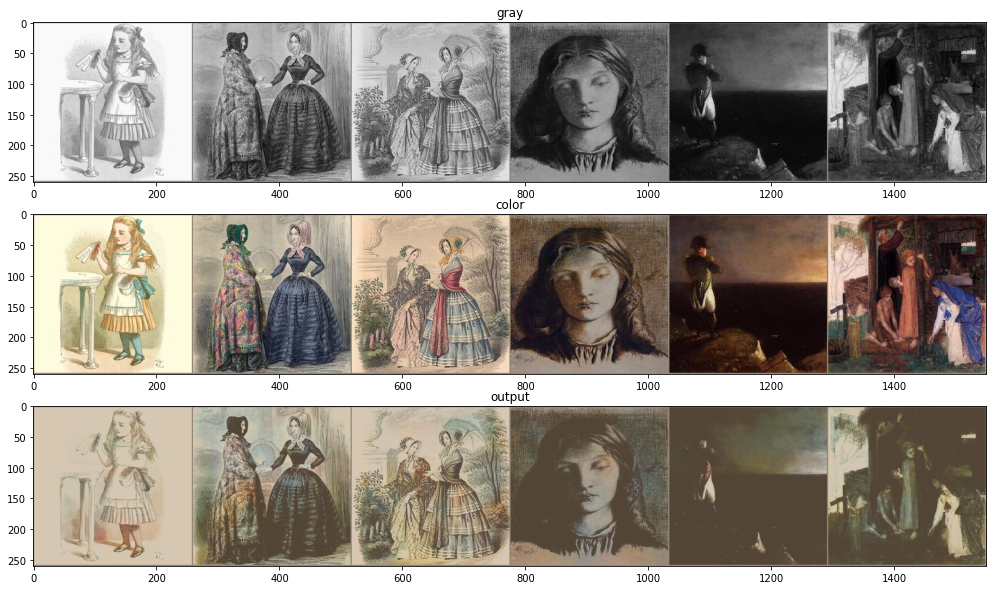

In [26]:
generator.eval()
discriminator.eval()

fig = plt.figure(figsize=(18,10))
sample_images(n_epochs, test_loader, 'test')

위에서 아래 순서대로 흑백-타켓-아웃풋 테스트 이미지입니다. 어떤 사진은 원본보다 출력이 더 잘 되는 것을 확인 할 수 있습니다. 생성자(Generator)에 U-NET이 추가된 cGAN 모델이 GAN 모델보다 색채를 예측하는 점에 있어서, 보다 나은 결과물을 생성하는 것을 확인해 볼 수 있었습니다.

모델 구조가 구체적인 목표에 맞춰 잘 짜여져 있다면, 이렇게 작은 데이터셋으로도 좋은 결과물을 만들 수 있습니다. 물론 많은 양의 질 좋은 데이터가 추가된다면, 향상 된 결과를 얻을 수 있습니다. 이제 학습된 모델을 바탕으로 여러분의 흑백 그림을 채색해보는게 어떨까요?